In [1]:
import pyaudio
import time
import queue
from av import audio
import numpy as np
import scipy.io.wavfile as wav
import librosa
import threading


#This library helps us in plotting the  audio
import matplotlib.pyplot as plt 


In [2]:
p = pyaudio.PyAudio()


CHUNK = 8820#8192 #int(config.MIC_RATE / config.FPS))
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100 #config.MIC_RATE 
RECORD_SECONDS = 10


In [10]:
#view mics on system
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

Input Device id  0  -  HDA Intel PCH: ALC298 Analog (hw:0,0)
Input Device id  6  -  Scarlett 2i2 USB: Audio (hw:1,0)
Input Device id  8  -  sysdefault
Input Device id  14  -  pulse
Input Device id  15  -  asymed
Input Device id  16  -  pulse_playback
Input Device id  17  -  pulse_capture
Input Device id  19  -  default


* recording


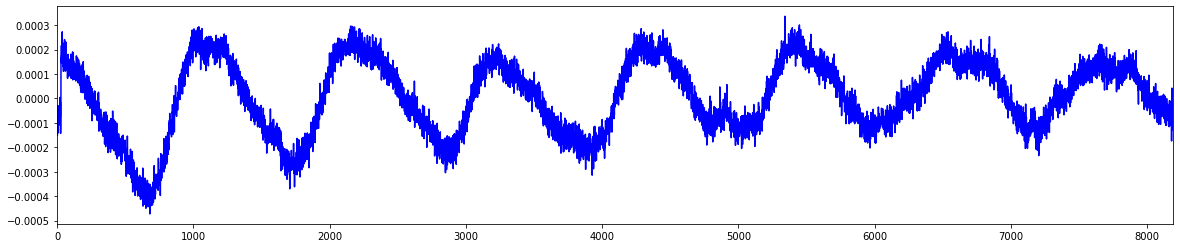

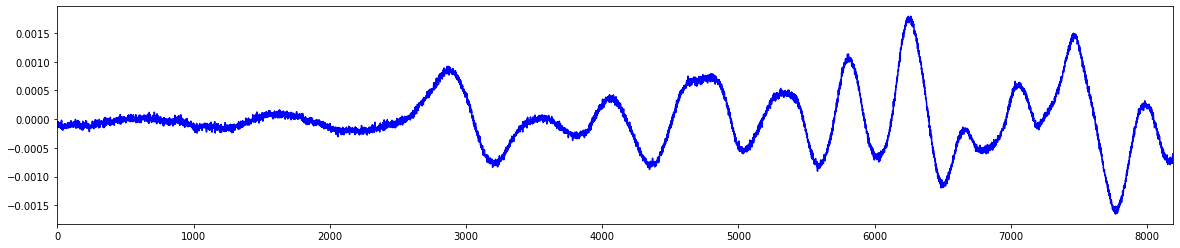

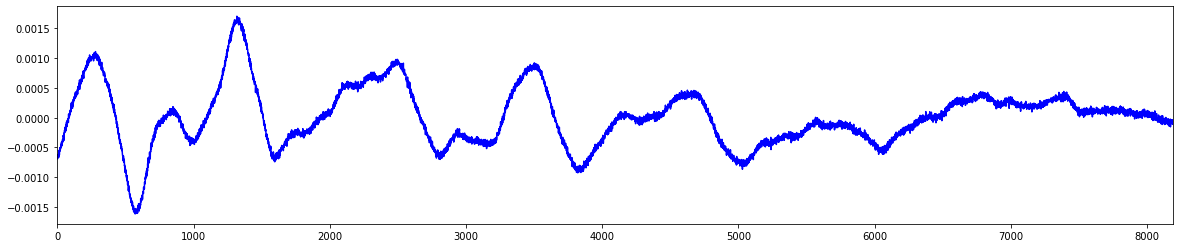

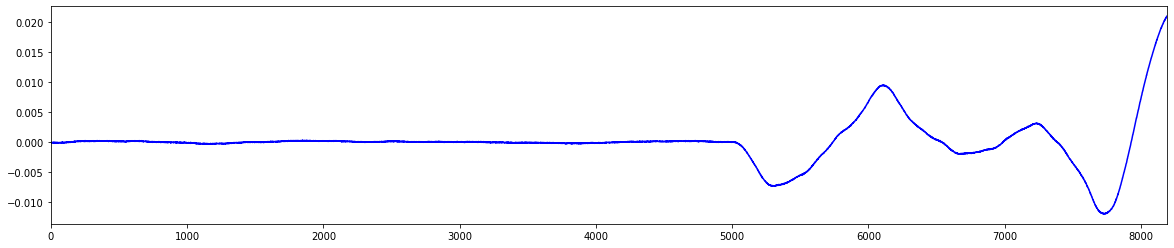

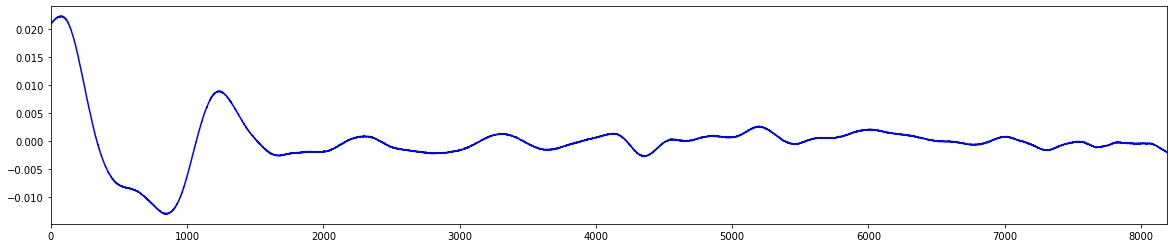

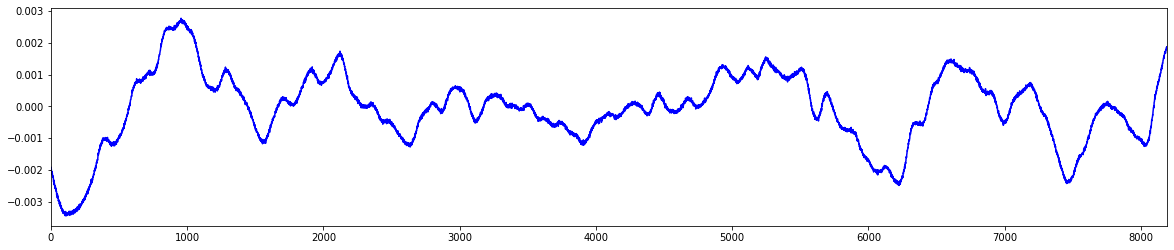

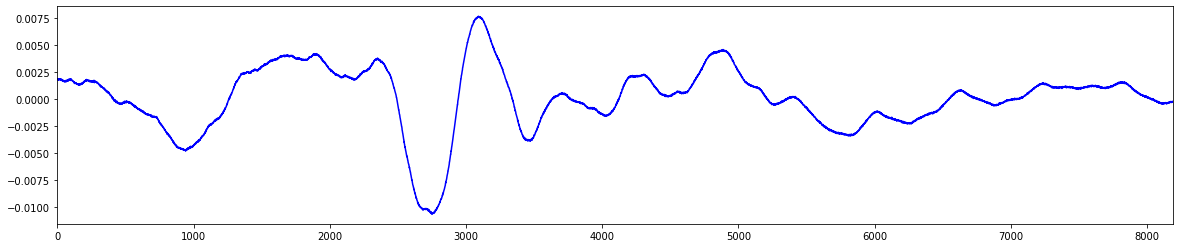

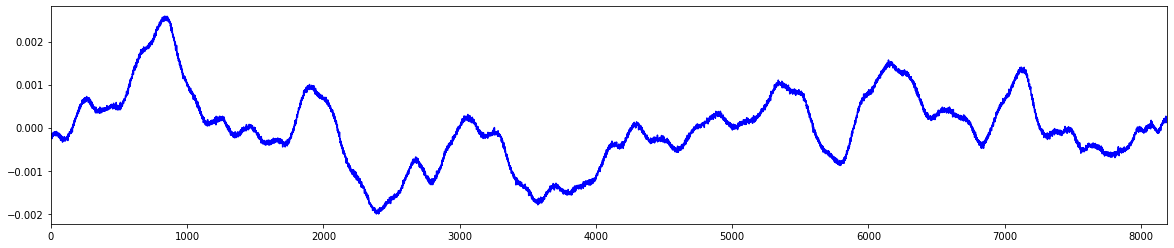

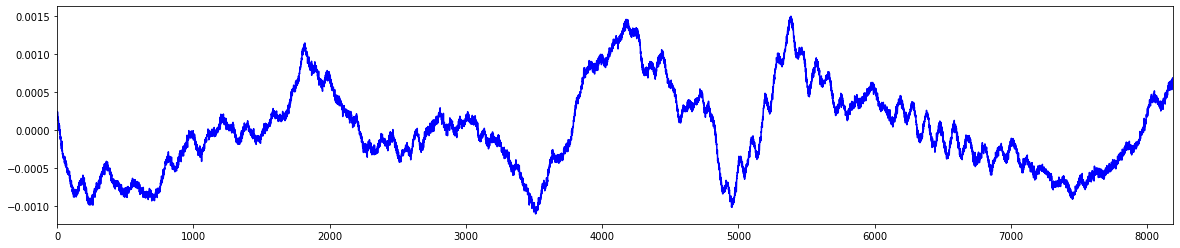

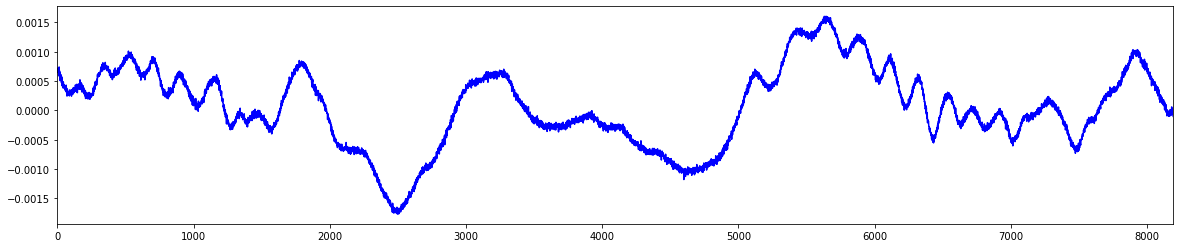

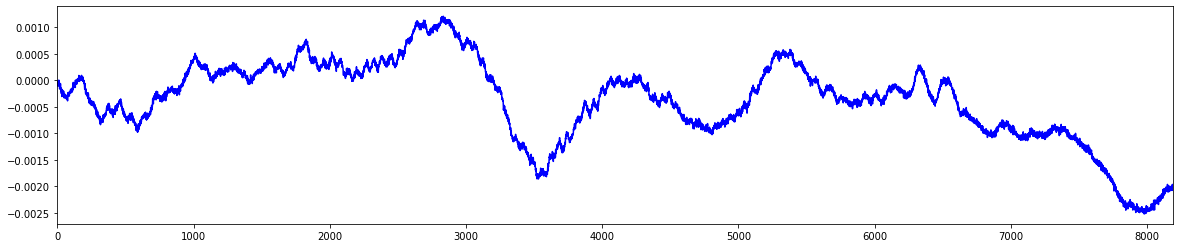

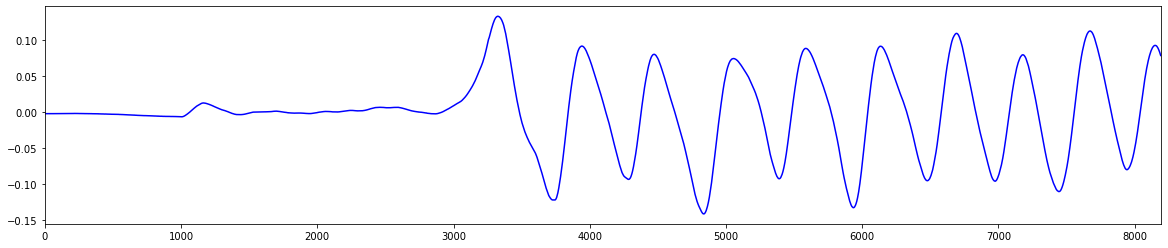

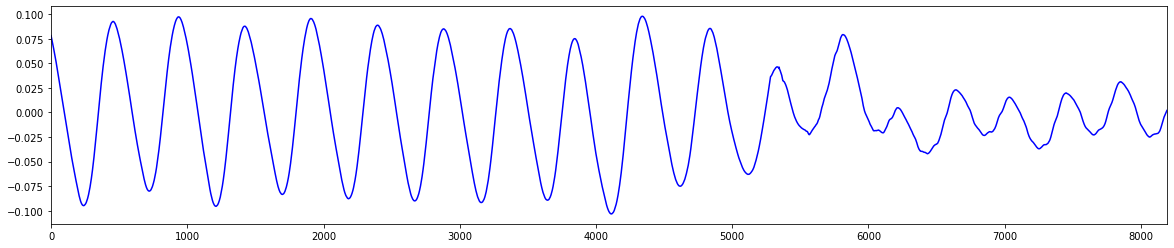

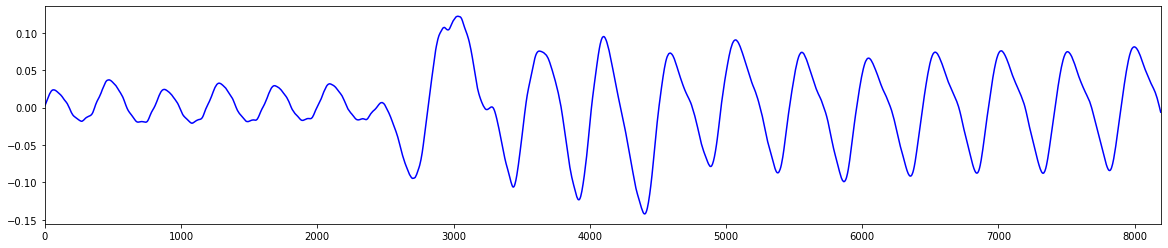

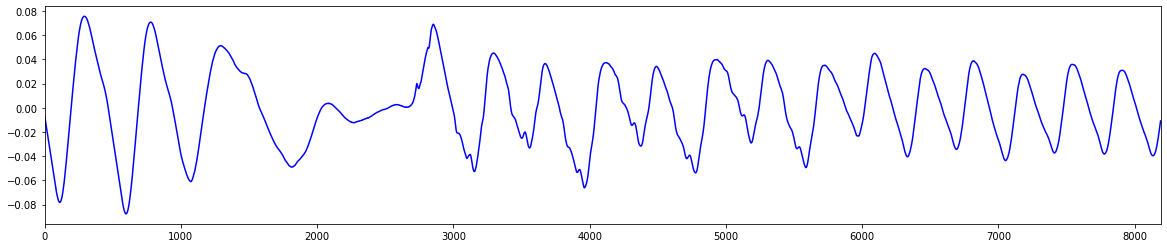

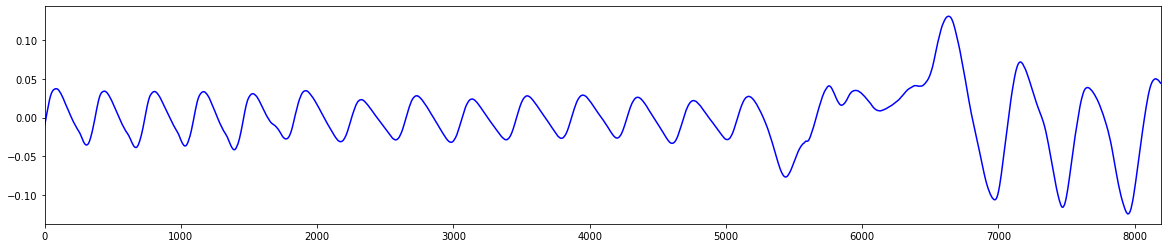

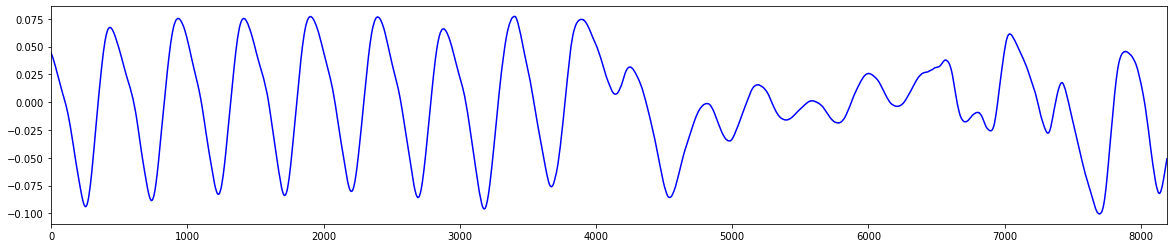

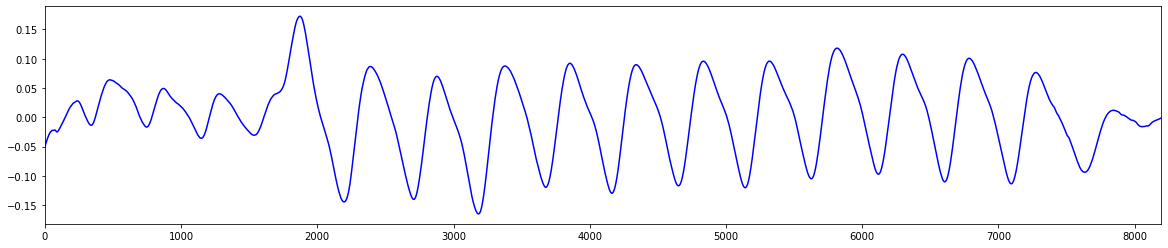

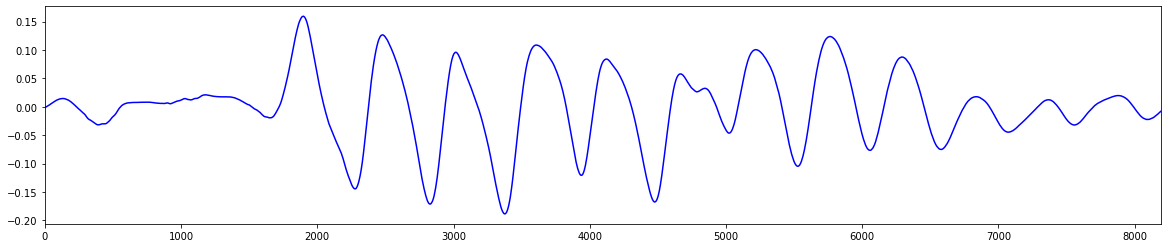

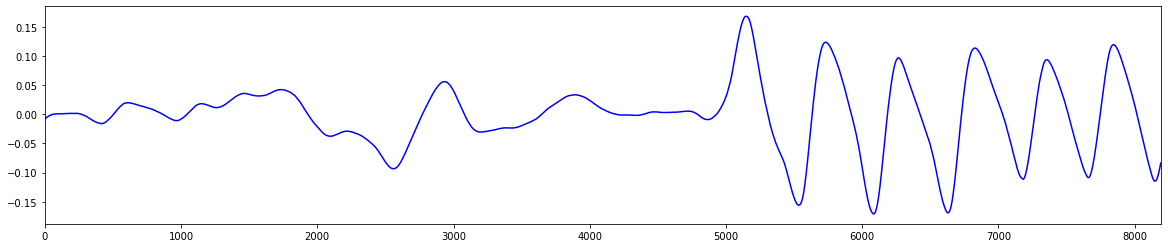

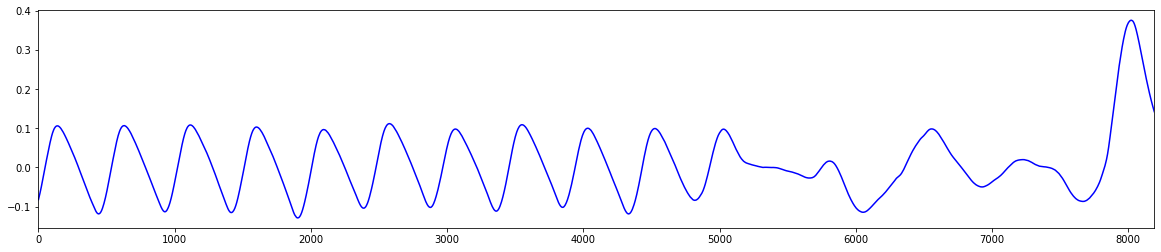

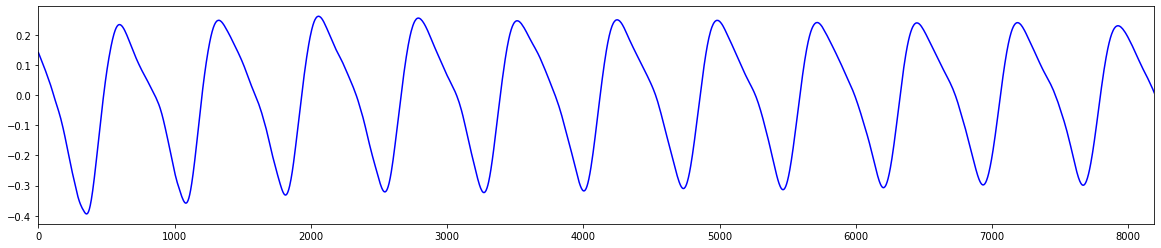

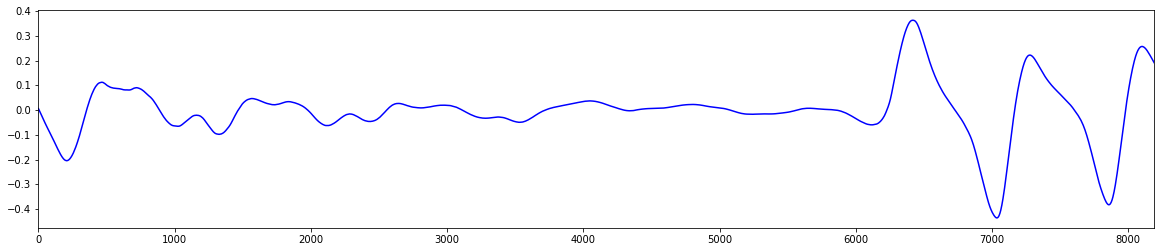

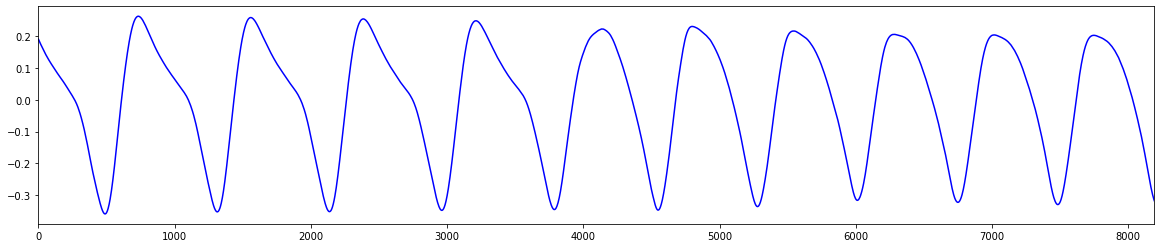

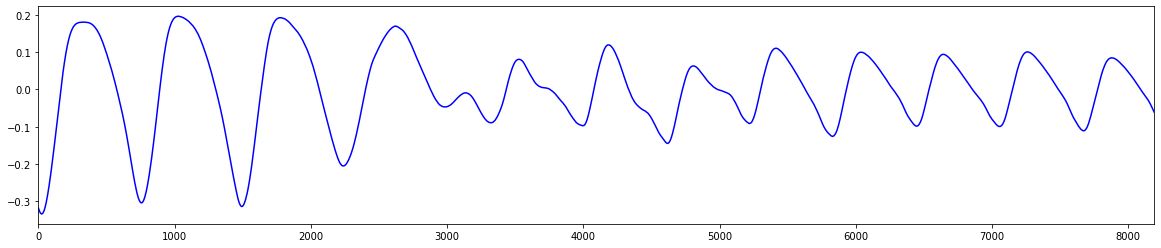

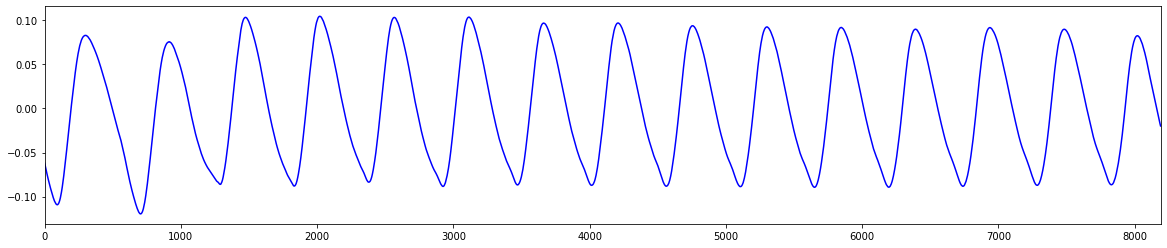

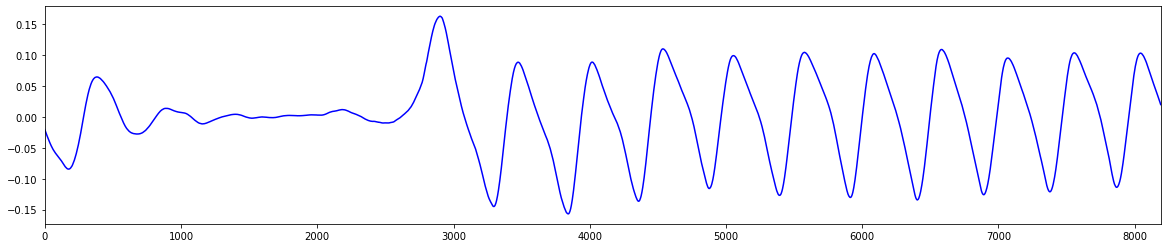

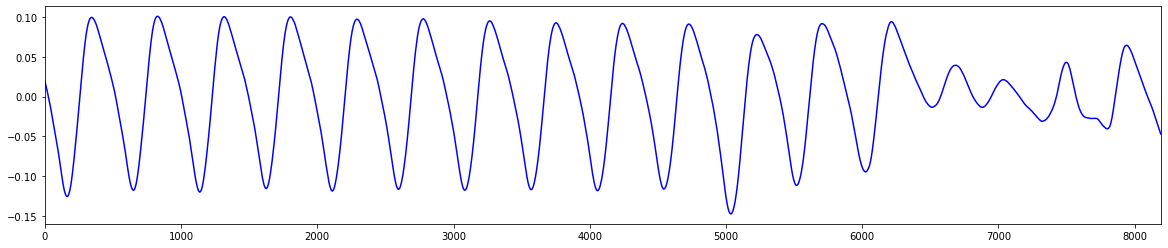

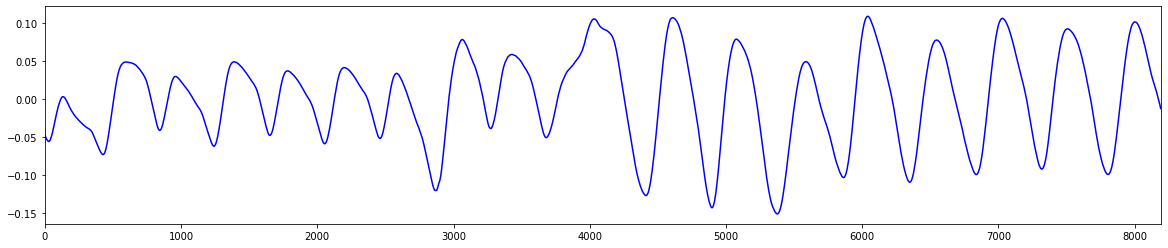

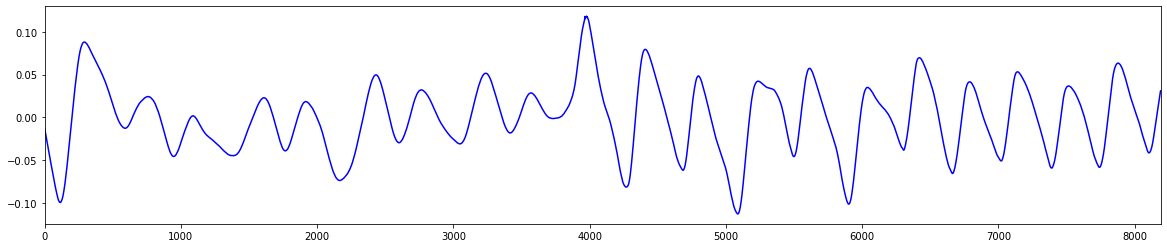

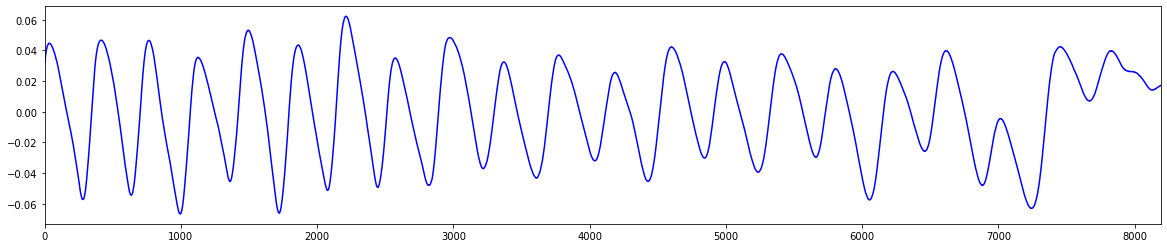

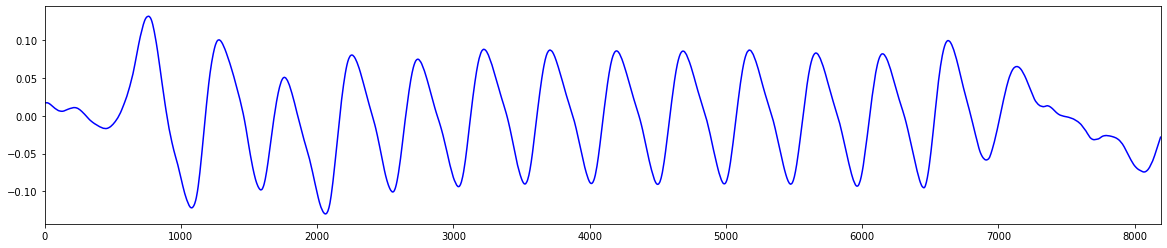

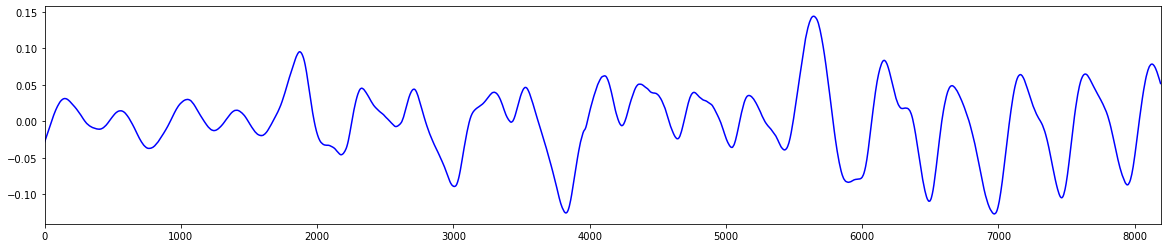

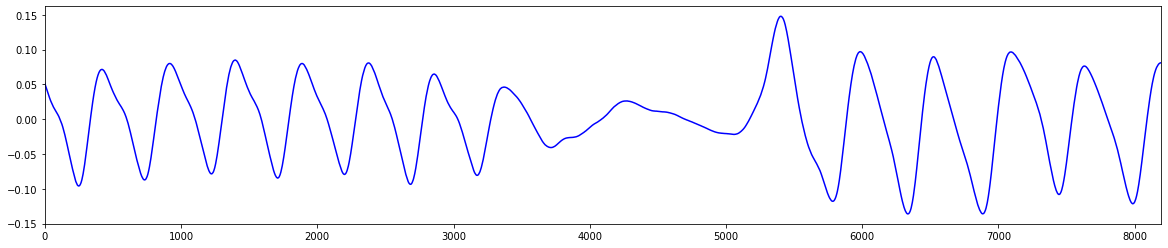

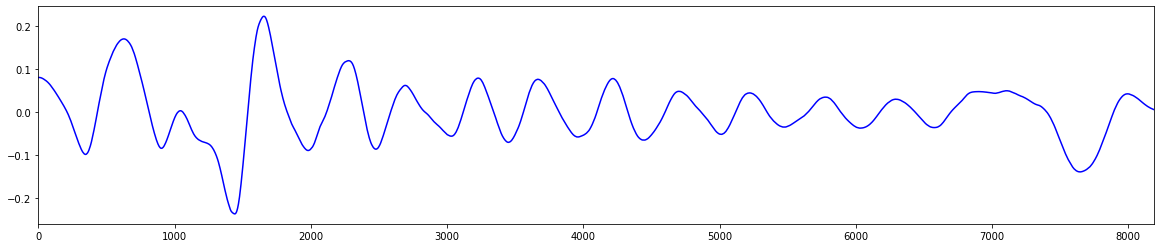

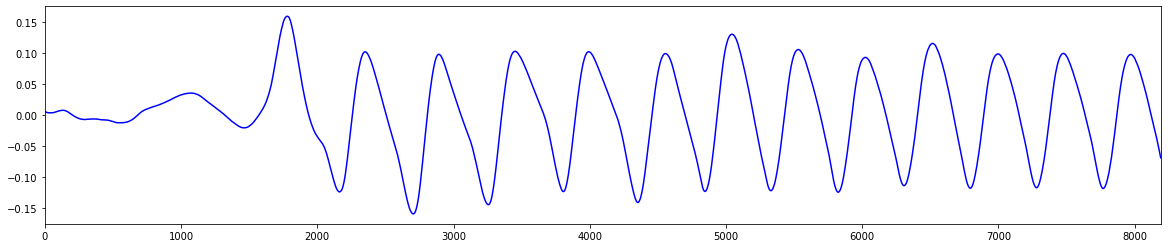

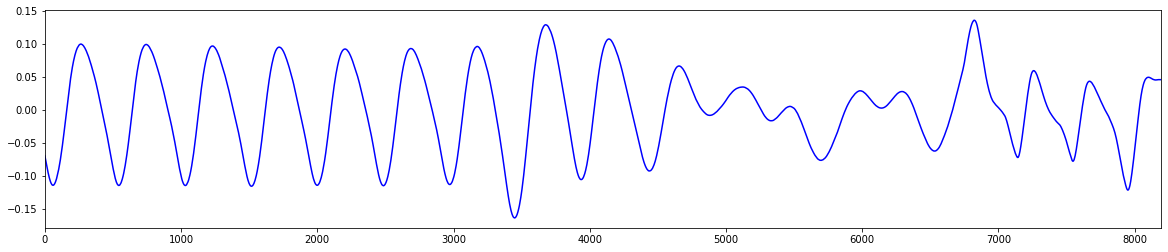

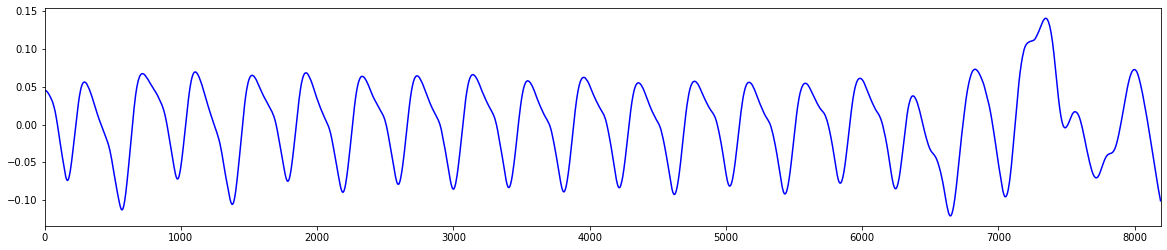

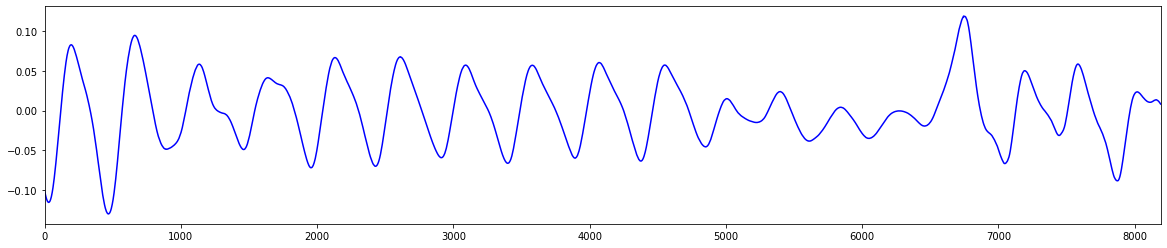

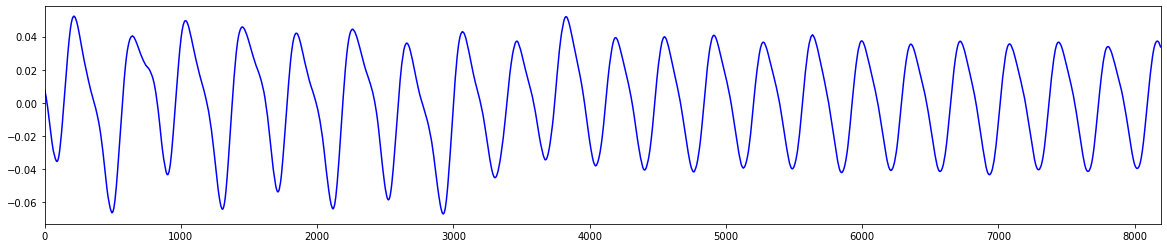

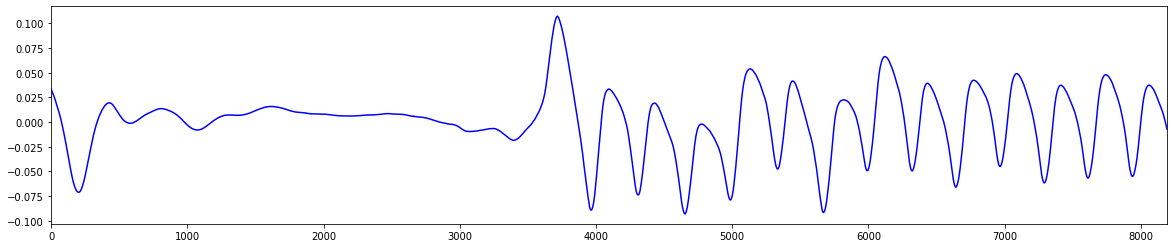

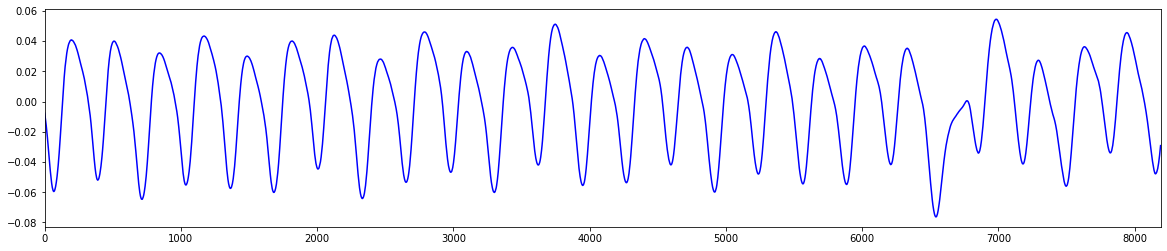

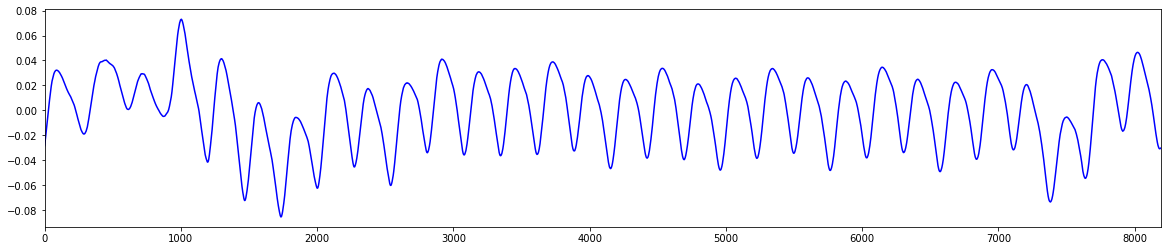

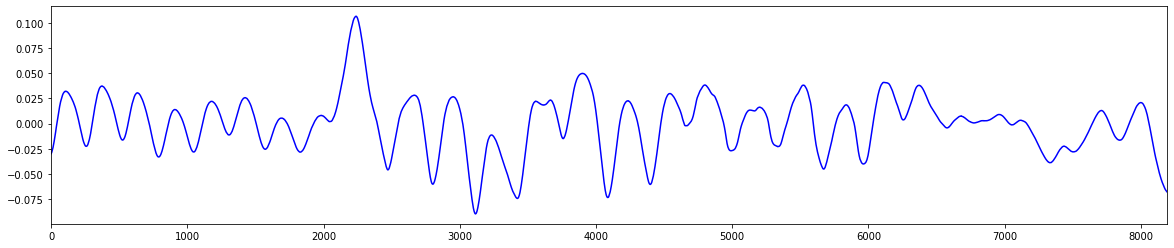

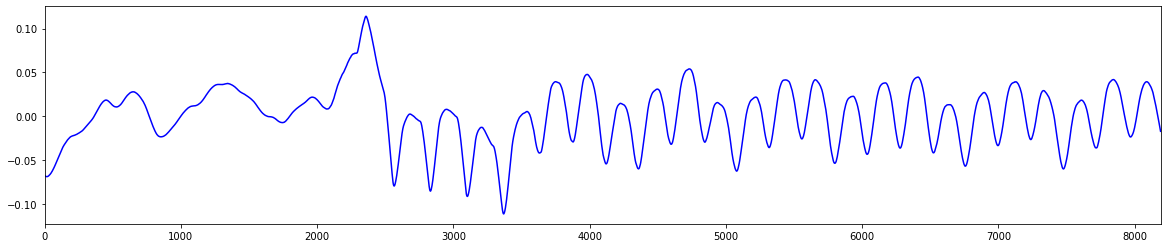

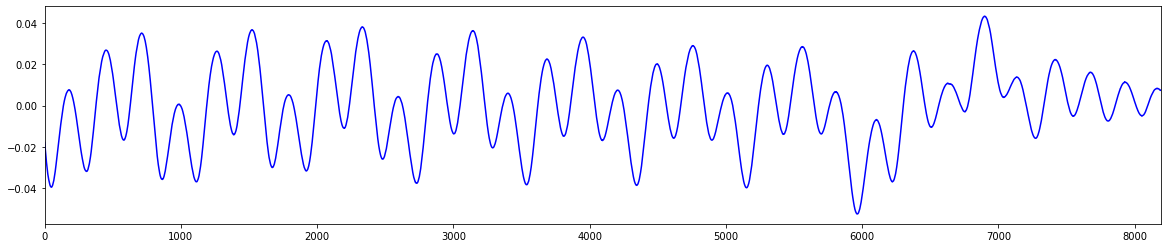

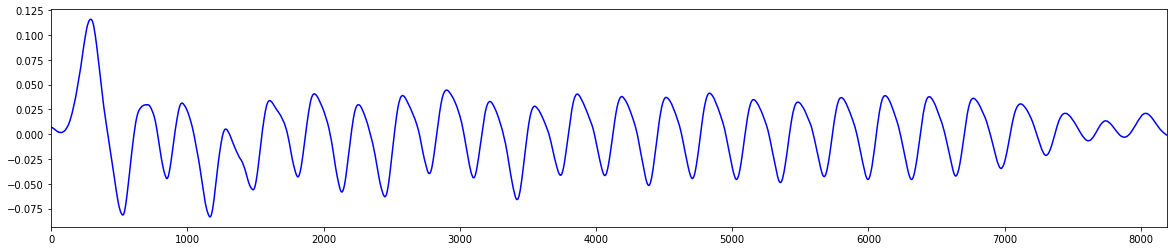

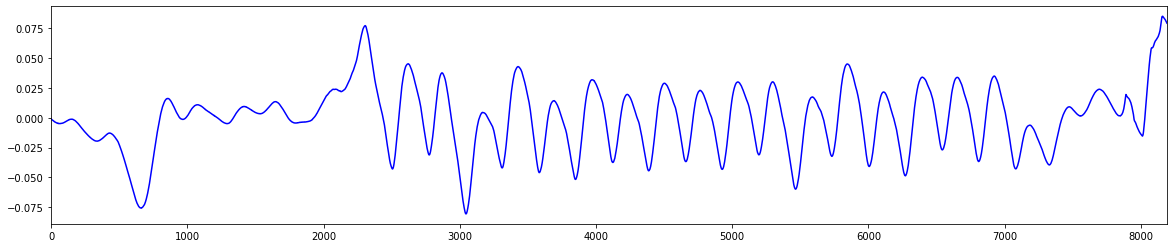

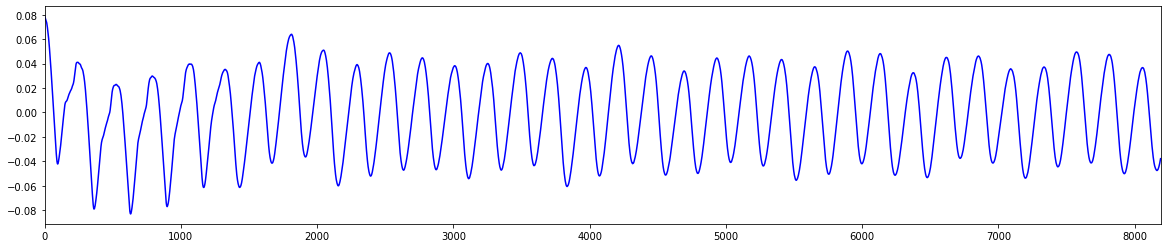

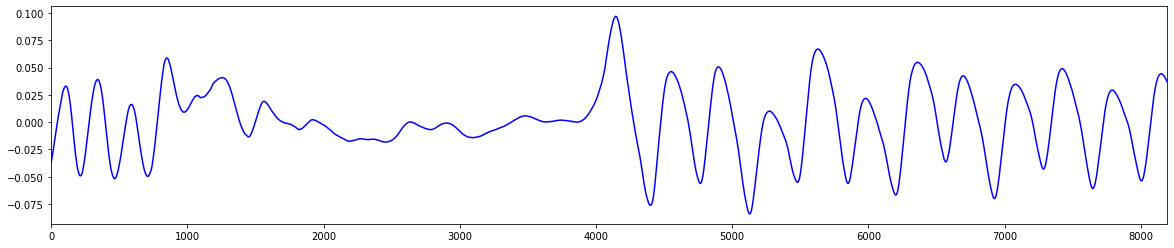

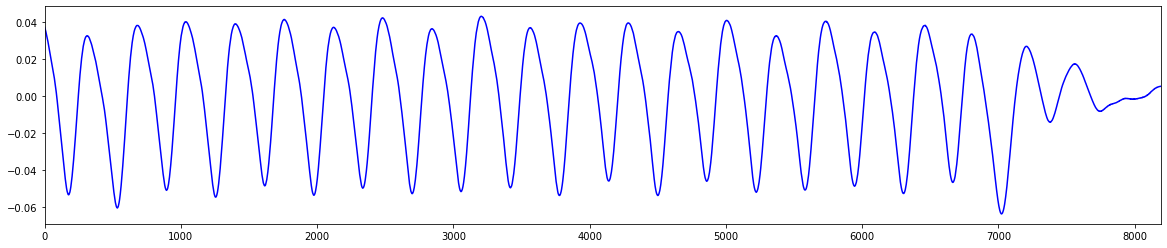

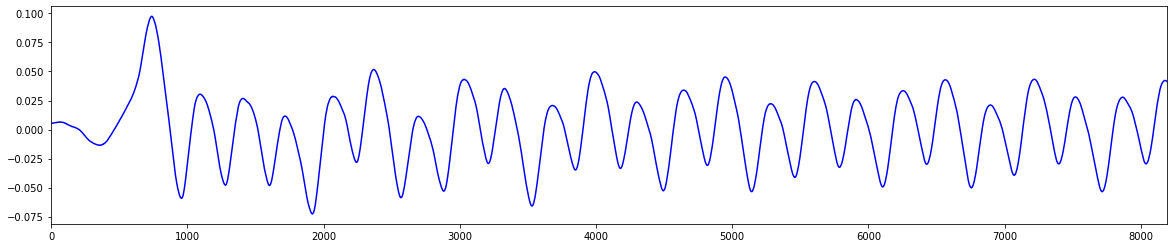

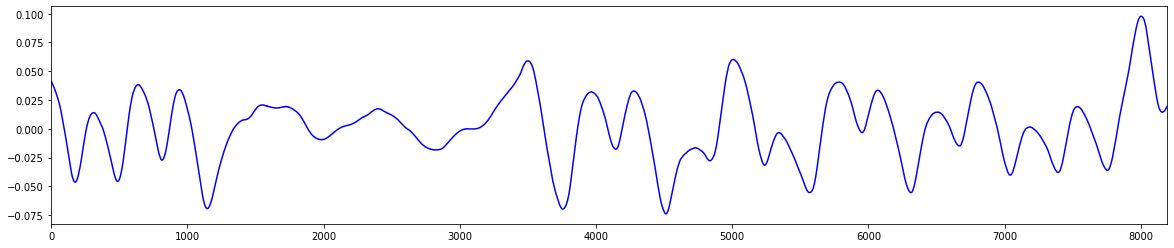

* done recording


In [5]:
#listen to mic

#choose input device:
input_device = 6

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                input_device_index = input_device
               )


print("* recording")

frameL = []
framesNP = []
frames = audio.fifo.AudioFifo()

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frameL.append(data)
    
    numpydata = np.frombuffer(data, dtype=np.float32)
    
    plotAudio2(numpydata)
    
    framesNP.append(numpydata)
    #aframe = audio.frame.AudioFrame.from_ndarray(data, 's32p',layout='mono')
    #frames.write(aframe)
    #time.sleep(0.1)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()


#print(frames)
#print(frames.get())

In [22]:
print(frames.get())

KeyboardInterrupt: 

In [11]:
print(frames.qsize())

5


In [12]:
import sys
print(sys.getsizeof(frames))
print(sys.getsizeof(frames)*frames.qsize())
print(sys.getsizeof(frames[0]))
print(sys.getsizeof(frames)*len(frames) * sys.getsizeof(frames[0]))

64
320


TypeError: 'Queue' object is not subscriptable

In [6]:
numpydata = np.hstack(framesNP)
frames = np.array(numpydata).copy()
#frames -= np.min(frames)
#frames /= np.max(frames)


print(frames.shape)

print(np.max(frames))
print(np.min(frames))


(434176,)
0.37556434
-0.43590903


In [8]:
gain = 0.8
frames = (frames / np.max(frames)) * gain

print(np.max(frames))
print(np.min(frames))

0.8
-0.92854196


In [9]:
'''
import wave



WAVE_OUTPUT_FILENAME = "recorded.wav"
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(p.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frameL))
waveFile.close()
'''

wav.write('out.wav',RATE,numpydata)

In [11]:



def plotAudio2(output):
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
        plt.plot(output, color='blue')
        ax.set_xlim((0, len(output)))
        plt.show()
        

class FrameHandler(threading.Thread):
    #record frames from stream and add to queue
    
    def __init__(self, chunk=2048, rate=44100, input_device=6, plot=False):
        threading.Thread.__init__(self)

        self.FORMAT = pyaudio.paFloat32
        self.CHANNELS = 1
        self.RATE = rate
        self.CHUNK = chunk
        self.input_device = input_device
        self.p = None
        self.stream = None
        self.data_queue = queue.Queue()
        self.plot = plot

    def start(self):
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format=self.FORMAT,
                                  channels=self.CHANNELS,
                                  rate=self.RATE,
                                  input=True,
                                  input_device_index=self.input_device,
                                  frames_per_buffer=self.CHUNK
                                 )#stream_callback=self.callback,
        
        print("framehandler started")
    
    def stop(self):
        self.stream.close()
        self.p.terminate()

    '''
    def callback(self, in_data, frame_count, time_info, flag):
        numpy_array = np.frombuffer(in_data, dtype=np.float32)
        librosa.feature.mfcc(numpy_array)
        return None, pyaudio.paContinue
    '''
    
    def mainloop(self):
        print("starting framehandler mainloop")
        while (self.stream.is_active()): # if using button you can set self.stream to 0 (self.stream = 0), otherwise you can use a stop condition
            data = self.stream.read(self.CHUNK)
            
            npdata = np.frombuffer(data, dtype=np.float32)
            
            self.data_queue.put(npdata)
            
            if self.plot:
                plotAudio2(numpydata)
            
            
            
class Sample:
    
    def __init__(self, frames, bpm):
        self.frame = frame
        self.bpm = bpm
            
class AudioHandler(threading.Thread):
    #calculate tempo & note onsets every specified interval (seconds)
    
    def __init__(self, interval=1.0, input_device=6, plot=False):
        threading.Thread.__init__(self)
        
        self.interval = interval
        self.RATE = 44100
        self.CHUNK = int((self.RATE * self.interval) // 5)
        print(self.CHUNK)
        self.input_device = input_device
        
        self.data_queue = queue.Queue()
        
        self.framehandler = FrameHandler(chunk=self.CHUNK, input_device=self.input_device, plot=plot)
        
    def start(self):
        self.framehandler.start()
        self.framehandler.mainloop()
        
    def mainloop(self):
        print("audiohandler mainloop started")
        while (self.framehandler.stream.is_active()):
            print(self.framehandler.data_queue.qsize())
            
            if self.framehandler.data_queue.qsize() >= 5:
                
                framesL = []
                for i in range(5):
                    framesL.append(self.framehandler.data_queue.get())
                
                #combine frames into 1 long frame spanning interval
                data_ronly = np.hstack(framesL)
                
                #copy data as data is read only
                data = np.array(data_ronly).copy()
                
                tempo, beats = librosa.beat.tempo(y=data, sr=self.RATE)
                
                sample = Sample(data, tempo)
                
                print(tempo)
                
                #self.data_queue.put(sample)
                

            else:
                #wait until framehandler reads enough
                time.sleep(0.02)
        
        
    def stop(self):
        self.framehandler.stop()
        
            


In [ ]:
audio = AudioHandler(interval=0.5, input_device=6)
print("audio initialized")
audio.start()
print("audio started")
audio.mainloop()
print("audio mainloop started")


4410
audio initialized
framehandler started
starting framehandler mainloop


In [ ]:
audio.stop()